## Lab 1 16.01.2017

Policy for sending after deadline

Lab 1 Deadline 23.01, after -1 point per day, 0 in a week after

### Load the graph

Find and plot PDF and CDF for the following networks:
* [Facebook network](http://www.leonidzhukov.net/hse/2015/networks/data/fb_Princeton.txt)

0. Load the graph. Plot descriptive statistics for the network (number of vertices, number of edges, number of connected components, radius, diameter, degree distribution, shortest path destribution)

In [410]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats
edges = np.loadtxt("fb_Princeton.txt", skiprows=4, dtype="i8,i8")
graph = nx.Graph()
graph.add_edges_from(edges)

In [411]:
connected_components = list(nx.connected_component_subgraphs(graph))
print('Total connected components', len(connected_components))
print('The largest connected component the majority of nodes:', len(largest_connected_component.nodes()))
largest_connected_component = list(connected_components)[0]
graph = largest_connected_component

('Total connected components', 10)
('The largest connected component the majority of nodes:', 6575)


### We cut off everything except the largest connected component

In [412]:
print('Vertices', len(graph.nodes()))
print('Edges', len(graph.edges()))
print('Radius', nx.radius(graph))
print('Diameter', nx.diameter(graph))

('Vertices', 6575)
('Edges', 293307)
('Radius', 5)
('Diameter', 9)


In [413]:
def plot_hist(degrees, bins=1000):
    yh, binEdges = np.histogram(degrees, bins=bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters, yh, '-', lw=1)
    plt.ylabel('count')
    plt.xlabel('degrees')
    plt.show()
    
def plot_log_log(degrees, bins=1000):
    yh, binEdges = np.histogram(degrees, bins=bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.loglog(bincenters, yh, '.', lw=2)
    plt.ylabel('count')
    plt.xlabel('degrees')
    plt.show()

Node degree distribution


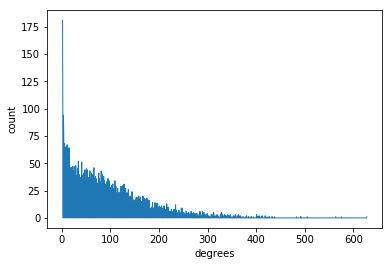

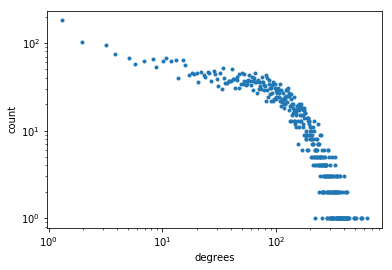

In [414]:
print('Node degree distribution')
node_degrees = graph.degree()
plot_hist(node_degrees.values())
plot_log_log(node_degrees.values())

Shortest path distribution is too heavy to compute on the whole graph. So we will sample about 20.0% connected nodes and compute shortest paths over them.
Sampled nodes: 1315


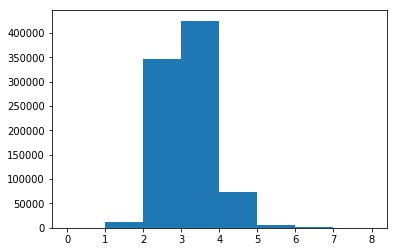

In [415]:
sample_amount = 0.2
print('Shortest path distribution is too heavy to compute on the whole graph. So we will sample about {}% connected nodes and compute shortest paths over them.'.format(sample_amount*100))
sampled_nodes = np.random.choice(graph.nodes(), size=int(sample_amount * len(graph.nodes())))
lenghts = []
for i, node in enumerate(sampled_nodes):
    for j in range(i+1, len(sampled_nodes)):
        node1 = sampled_nodes[j]
        path_len = nx.shortest_path_length(graph, source=node, target=node1)
        lenghts.append(path_len)
lengths = np.array(lenghts)
print 'Sampled nodes: {}'.format(len(sampled_nodes))
plt.hist(lengths, bins=range(min(lengths), max(lengths)))
plt.show()

### Power Law

1) Does it satisfy power law?

In [416]:
print(np.random.choice(['Yes', 'No']))

No


## Now let's check it

### Determine alpha via linear regression

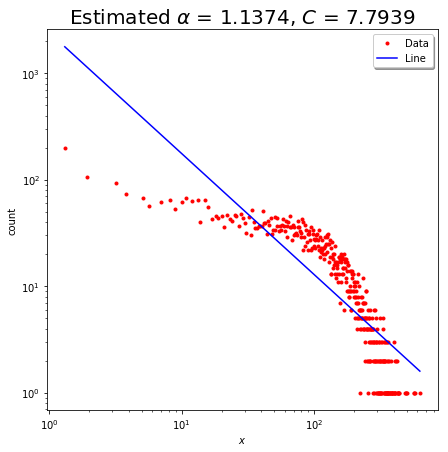

In [417]:
yh, binEdges=np.histogram(degrees, bins=1000)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
idx = np.ix_(yh != 0)
x_est = np.log(bincenters[idx])
y_est = np.log(yh[idx])
s = len(x_est)

X = np.vstack([np.ones(s), x_est]).T
Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

idx = np.argsort(x_est)
yt = np.exp(X[idx,:].dot(Beta))
xt = np.exp(X[idx,1])

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
ax.loglog(bincenters, yh, '.r', label='Data') 
ax.loglog(xt, yt, 'b', label='Line')
plt.ylabel('count')
plt.xlabel('$x$')
ax.legend(loc='upper right', shadow=True)

a_linreg = -Beta[1]
c_linreg = Beta[0]
plt.title('Estimated $\\alpha$ = {0:1.4f}, $C$ = {1:1.4f}'.format(a_linreg, c_linreg), fontsize=20)
plt.show()

We can estimate goodness-of-fit via $R^2$

In [418]:
y_hat = X[idx,:].dot(Beta)
print 'R squared:', r2_score(y_hat, y_est)
print 'Fine fit'
mse = (np.square(y_hat - y_est)).mean()
print 'MSE', mse

R squared: 0.5831905763191095
Fine fit
MSE 0.5264471347618044


## Satisfies power law

2) Find max and mean values of incoming and outcoming node degrees

### As the graph is undirected, incoming degrees equal outcoming degrees

In [419]:
node_degrees = graph.degree()
degrees = np.array(node_degrees.values())
max_in_degree = np.max(degrees)
max_out_degree = max_in_degree
mean_in_degree = np.mean(degrees)
mean_out_degree = mean_in_degree
print('max in degree', max_in_degree)
print('mean in degree', mean_in_degree)
print('max out degree', max_out_degree)
print('mean out degree', mean_out_degree)

('max in degree', 628)
('mean in degree', 89.21885931558936)
('max out degree', 628)
('mean out degree', 89.21885931558936)


3) Find $\alpha$ via Maximum Likelihood and calculate $\sigma^2$

In [420]:
print('Estimate x_min using alpha and C obtained from linear regression')
x_min_est = float(np.power(c_linreg/(a_linreg-1), 1-a_linreg))
x_min_est

Estimate x_min using alpha and C obtained from linear regression


0.5741009144988597

In [421]:
# Max likelihood estimator for alpha
def alpha_mle(x, x_min):
    x = np.array(x)
    n = x.shape[0]
    return 1+n*1/(np.sum(np.log(x/x_min)))

a_mle = alpha_mle(degrees, x_min_est)
a_mle

1.223043996446178

In [422]:
sigma_squared = ((a_mle - 1)/np.sqrt(degrees.shape[0]))**2

In [423]:
print('Alpha estimated by MLE', a_mle)
print('Sigma squared estimated', sigma_squared)

('Alpha estimated by MLE', 1.223043996446178)
('Sigma squared estimated', 7.56633069972359e-06)


4) Determine $x_{min}$ via Kolmogorov-Smirnov test

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


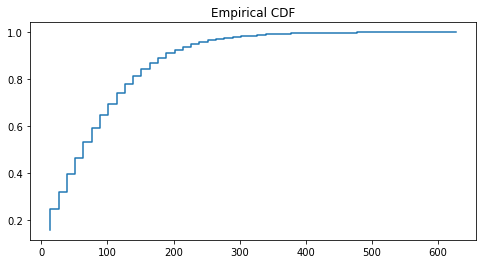

In [424]:
num_bins = 50
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Empirical CDF')
counts, bin_edges = np.histogram(data, bins=num_bins, normed=True)
ecdf = np.cumsum(counts)
ecdf = ecdf/ecdf[-1]
ax.step(bin_edges[1:], ecdf)
plt.show()